In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import ephem
import math
from datetime import timedelta
import matplotlib.dates as mdates
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.patches import ConnectionPatch


In [3]:
def calculate_solar_cos_zenith(datetime_obj,     
                               latitude  = 38.980762,   # ERW
                               longitude = -107.005017):

    observer = ephem.Observer()

    observer.lat = str(latitude)
    observer.lon = str(longitude)
    observer.date = datetime_obj

    sun = ephem.Sun(observer)
    solar_altitude = sun.alt

    # Calculate zenith angle (90 degrees - solar altitude)
    zenith_angle = math.pi / 2.0 - solar_altitude

    # Calculate cosine of zenith angle
    cos_zenith = math.cos(zenith_angle)

    return cos_zenith

def calculate_solar_az(lat, lon, datetime_obj):
    observer = ephem.Observer()
    observer.lat = str(lat)
    observer.lon = str(lon)
    observer.date = datetime_obj
    observer.pressure = 0
    sun = ephem.Sun(observer)
    return sun.az

In [4]:
date_times = pd.date_range(start='2020-12-21', end='2021-10-01', freq='1min')

In [5]:
df = pd.DataFrame(data={'cza':[calculate_solar_cos_zenith(x) for x in date_times]}, index=date_times)
df['albedo'] = np.zeros(len(df)) + 1.
df['swtoa'] = 1365*.8*df.cza.clip(lower=0)

### Functions 

In [6]:
def return_date_closest_to_zero(df):
    if df.min() > 0:  # we are never cooling the surface 
        return 9999
    if df.max() < 0:   # we are never warming the surface 
        return -9999
    doy = df.lte(0).idxmax().dayofyear
#    if doy > 330:  
#        return 365 - doy   # this is because we are using Jan 1 through 
    return doy


### constants

In [7]:
S0 = 1365
t_clear = .8 


### open up real data 


In [8]:
#master_df = pd.read_csv("/global/homes/r/rudisill/gshare2/will_data/crf_files/master_df_for_idealized_plots.csv", index_col=0, parse_dates=True)
master_df = pd.read_csv("/global/homes/r/rudisill/gshare2/will_data/crf_files/master_df_sail_cre.csv", index_col=0, parse_dates=True)                        
#master_df_sail_cre
mdf1d = master_df.resample("1d").mean()
mdf1d = master_df.resample("1d").mean()
mdf1d['tau'] = -1*np.log(mdf1d.qcrad_swd/mdf1d.rrtmg_swd_clear)

In [9]:
hist,bins = np.histogram(mdf1d['tau'],20)

In [10]:
bin_center = bins[1:] - bins[:-1] + bins[1:]

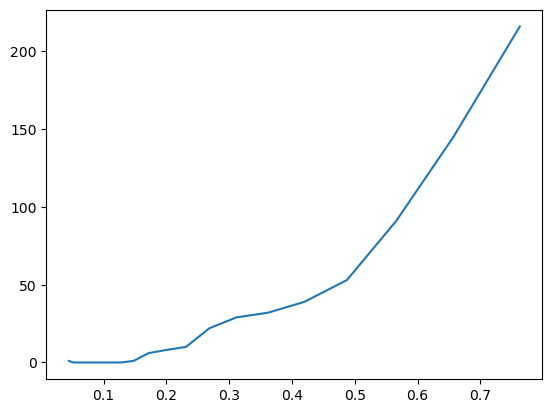

In [11]:
plt.plot(np.exp(-1*bin_center), hist)

### make transmissivity vs. crf_lw plot

In [235]:
import scipy.stats as stats
#fig, ax = plt.subplots(1, figsize=(3,2) )#2,3, figsize=(5,2.5), gridspec_kw={"height_ratios":[1,.05]})

cre_sw = (master_df.qcrad_swd - master_df.rrtmg_swd_clear).where(master_df.shadow<.3).fillna(0)
cre_lw = (master_df.qcrad_lwd - master_df.rrtmg_lwd_clear)
crf_sw = (cre_sw * (1-master_df.albedo))
crf_lw = cre_lw + (master_df.ml_lwu_clear - master_df.qcrad_lwu)
crf_net = crf_sw + crf_lw
cre_net = cre_sw + cre_lw

kolias = xr.open_dataset("/global/homes/r/rudisill/gshare/sail_data_will/data_store_sail_period/kollias/cbh_kolias2.nc").to_pandas()
cloud_present_kolias = kolias.copy()
cloud_present_kolias[cloud_present_kolias == -1] = 0
cloud_present_kolias[cloud_present_kolias > 6000 ] = 0
cloud_present_kolias[cloud_present_kolias > 0] = 1
master_df['cloud_present'] = cloud_present_kolias.resample("1h").mean().reindex(master_df.index)
###

def make_trans_plot(ax):
    cmap    = plt.get_cmap('Blues')
    cmap.set_under('none')
    cmap.set_over('none')

    tauhr = master_df[['rrtmg_swd_clear', 'qcrad_swd', 'cloud_present']].dropna()
    tau1d = tauhr.resample("1d").mean()
    trans1d = tau1d.qcrad_swd / tau1d.rrtmg_swd_clear 
    trans1d = trans1d[tau1d.cloud_present > .8]  #### NOTE THIS 
    #cfrac1d = tauhr.cloud_present.resample("1d").mean()

    #### do lw and transmissibvity 
    xmin=0.
    xmax=150.
    ymin=0.
    ymax=1

    xdat = crf_lw.resample("1d").mean().loc[trans1d.index] #tauhr['cre_lw']
    ydat = trans1d # np.exp(-1*tauhr['tauhr'])


    X, Y = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([xdat, ydat])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)

    cfset = ax.pcolormesh(X, Y, Z, cmap=cmap, vmin=.001)
    ax.contour(X, Y, Z, colors=['black'], levels=[.01, .03, .05], linewidths=.5)
#    cbar = fig.colorbar(cfset, ax=ax, orientation='vertical')
 #   cbar.set_label('Density')


    ax.scatter(xdat, ydat,  s=1, alpha=1, color='red')
    ax.set_xlim(10,80)#[xmin, xmax])
    ax.set_ylim(0,1.0) #[ymin, ymax])
    #ax.contour(X, Y, Z, colors='k', linewidths=.5)


    ax.set_ylabel(r"T$_D$")
    ax.set_yticks([0, .25, .5, .75, 1])

    return ax, cfset

In [13]:
cza_mean_daily = df.cza.clip(lower=0).resample("1d").mean()


### CRF Transition as a function of crf lw

In [14]:
np.exp(-.3), np.exp(-.8), np.exp(-1.4)

(0.7408182206817179, 0.44932896411722156, 0.2465969639416065)

In [15]:
dfx = df["2021-01-01":"2021-06-20"]

In [16]:
# albedo_vec = np.linspace(1.0, .1, 100)
# crflwnet  = np.linspace(0, 100, 100)


# def get_transition_matrix(cloud):
#     dmat = np.zeros((len(crflwnet), len(albedo_vec)))
#     cfrac = 1.
#     for j,albedo in enumerate(albedo_vec):
#         for i,lw in enumerate(crflwnet):
#             cza_mean_daily = dfx.cza.clip(lower=0).resample("1d").mean()
#             crf_daily = lw + (1 - albedo) * S0 * t_clear * cza_mean_daily * (np.exp(-cloud * cfrac) - 1) 
#             dmat[i,j] = return_date_closest_to_zero(crf_daily)
#     return dmat


# # do it for thicker clouds 
# dmat1 = get_transition_matrix(.3)
# datamax1 = dmat1[np.where(dmat1 < 9999)].max()

# dmat2 = get_transition_matrix(.8)
# datamax2 = dmat2[np.where(dmat2 < 9999)].max()

# dmat3 = get_transition_matrix(1.4)
# datamax3 = dmat3[np.where(dmat3 < 9999)].max()

### let's write out the formula for daily and 24h CRF_NET transition date

$S_0$ is the solar constant, which we let equal 1365.5 W m^2.

We can write out the incident shortwave on the ground as: 

$SW \downarrow = S_0 T_k T_0 \overline{cza_k}$

$T_k$ is the cloud transmissivity and $T_0$ is the clear sky transmissivity. And we let $cza_k$ be the cosine of the solar zenith angle, and the overbar is the average operator. $cza$ is defined such that it is 0 when it is below the horizon.

The net shortwave radiation at the surface is given by:

$SW_{NET} = (1-\alpha)SW_\downarrow$

It follows that the shortwave CRF is therefore given by: 

$CRF_{SW} = SW_{all-sky}\downarrow  - SW_{clear-sky}\downarrow$

Which we can rewrite as: 

$CRF_{SW} = \\
= SW_{all-sky, NET}  - SW_{clear-sky, NET} \\
= (1-\alpha)S_0 T_k T_0 \overline{cza_k} - (1-\alpha)S_0 T_0 \overline{cza_k} \\
= (1-\alpha)S_0 T_0 \overline{cza_k} (T_k - 1)$

It can be somewhat more convenient to write out the Transmissivity as something more similat to the cloud optical depth, $\tau$, which is simpliy the negative log of the transmissivity (i.e. $\tau = -\log(T)$).

So, after substituting that, we have an expression:

$CRF_{SW} = \\
= (1-\alpha)S_0 T_0 \overline{cza_k} (e^{-\tau} - 1)$

If we treat the free parameters in this expression as the albedo, the cosine of the solar zenith angle, and the cloud optical depth, and the cloud longwave radiative forcing, then we can explore the parameter space of the following equation: 

$CRF_{NET} = \\
= CRF_{LW,k} + (1-\alpha_k)S_0 T_0 \overline{cza_k} (e^{-\tau_k} - 1)$



### Daytime only versus 24h CRF_NET transiton
To compute the 24h cycle CRF transition date, then we simply compute the 24h average cosine of the solar zenith angle (with a 0 value where the sun is below the horizon). To compute the daytime only CRF transition, we restrict the average to only times when the sun is above the horizon. This is achieved by using pandas operations combined with the '.resample("1d")' method.


#### do it for daytime only


In [17]:
albedo_vec = np.linspace(1.0, .1, 100)
crflwnet  = np.linspace(0, 100, 100)


# def get_transition_matrix(cloud):
#     dmat = np.zeros((len(crflwnet), len(albedo_vec)))
#     cfrac = 1.
#     for j,albedo in enumerate(albedo_vec):
#         for i,lw in enumerate(crflwnet):
#             # this is the key line 
#             cza_mean_daily = df.cza.where(dfx.cza>0).dropna().resample("1d").mean()
#             crf_daily = lw + (1 - albedo) * S0 * t_clear * cza_mean_daily * (np.exp(-cloud * cfrac) - 1) 
#             dmat[i,j] = return_date_closest_to_zero(crf_daily)
#     return dmat


# # do it for thicker clouds 
# dmat4 = get_transition_matrix(.3)
# datamax4 = dmat4[np.where(dmat4 < 9999)].max()

# dmat5 = get_transition_matrix(.8)
# datamax5 = dmat5[np.where(dmat5 < 9999)].max()

# dmat6 = get_transition_matrix(1.4)
# datamax6 = dmat6[np.where(dmat6 < 9999)].max()

In [18]:
# for i,dmat in enumerate([dmat1, dmat2, dmat3, dmat4, dmat5, dmat6]):
#     np.save("/global/homes/r/rudisill/gshare2/will_data/crf_files/dmat%s.npy"%i, dmat)

In [19]:
dmat1 = np.load("/global/homes/r/rudisill/gshare2/will_data/crf_files/dmat%s.npy"%0)
dmat2 = np.load("/global/homes/r/rudisill/gshare2/will_data/crf_files/dmat%s.npy"%1)
dmat3 = np.load("/global/homes/r/rudisill/gshare2/will_data/crf_files/dmat%s.npy"%2)
dmat4 = np.load("/global/homes/r/rudisill/gshare2/will_data/crf_files/dmat%s.npy"%3)
dmat5 = np.load("/global/homes/r/rudisill/gshare2/will_data/crf_files/dmat%s.npy"%4)
dmat6 = np.load("/global/homes/r/rudisill/gshare2/will_data/crf_files/dmat%s.npy"%5)

In [20]:
molist = np.array([0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])

monmlist = ["Jan",
            "Feb",
            "Mar",
            "Apr",
            "May",
            "Jun",
            "Jul",
            "Aug",
            "S",
            "O",
            "N",
            "D"]


#labelist = [-11] + list(molist.cumsum()[0:6]) + [170]
labelist =  list(molist.cumsum()[0:6]) + [170]

In [21]:
#molistnames = ["Dec. 21"] + monmlist[0:6] + ["Jun. 20"]
molistnames = monmlist[0:6] + ["Jun. 20"]

/tmp/ipykernel_1576255/2604200963.py:12: UserWarning: The following kwargs were not used by contour: 'linecolors'
  ax.contour(x,y,dmat, levels=[6+31+28+20], linecolors='black', linewidths=1, linestyles='--')


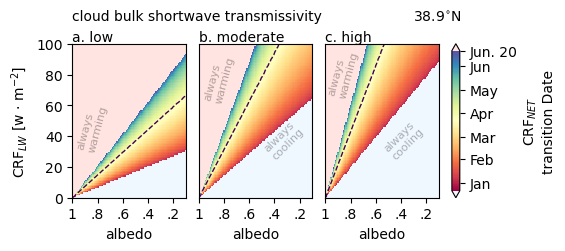

In [22]:
#fig,axx = plt.subplots(1, 5, figsize=(6,2), gridspec_kw={'width_ratios': [.4, 1,1,1,.07]}, sharey=False)
fig,axx = plt.subplots(1, 4, figsize=(5,2), gridspec_kw={'width_ratios': [1,1,1,.07]}, sharey=False)

cmap    = plt.get_cmap('Spectral')
cmap.set_under('aliceblue')
cmap.set_over('mistyrose')


def plotmat(dmat,ax):
    x,y = np.meshgrid(albedo_vec, crflwnet)
    c=ax.pcolormesh(x, y, dmat, cmap=cmap, vmax=170, vmin=-10, shading='auto')
    ax.contour(x,y,dmat, levels=[6+31+28+20], linecolors='black', linewidths=1, linestyles='--')
    ax.set_xlabel('albedo')
    ax.set_ylabel("")
    ax.set_xlim(1,.1)
    ax.set_ylim(25,90)
    return c 

crf_lab = r'CRF$_{LW}$ [w $\cdot$ m$^{-2}$]'
cb = plotmat(dmat1, axx[0])
cb = plotmat(dmat2, axx[1])
cb = plotmat(dmat3, axx[2])
cbar = fig.colorbar(cb, cax=axx[3], extend='both')
cbar.set_ticks(labelist)
cbar.set_ticklabels(molistnames)
cbar.set_label(r"CRF$_{NET}$" + "\ntransition Date")
#########################################
lp = .24 # * .9
w  = .1  #* .9
h  = .15 
tp = .3
dtp = .3


for j in [1,2]:
    axx[j].set_yticklabels([])
    axx[j].set_yticks([])

for j in [0,1,2]:
    axx[j].set_xticks([1., .8,.6,.4,.2])
    axx[j].set_xticklabels(["1", ".8", ".6", ".4", ".2"])
    
    
axx[0].text(0, 1.02, r"a. low",  transform=axx[0].transAxes, fontsize=10)
axx[1].text(0, 1.02, r"b. moderate",  transform=axx[1].transAxes, fontsize=10)
axx[2].text(0, 1.02, r"c. high", transform=axx[2].transAxes, fontsize=10)




#axx[0].set_yticks([30, 45, 60, 75, 90])

for j in [0,1,2]:
    axx[j].set_ylim(0,100)


axx[0].text(.97, 30, 'always\nwarming', rotation=75, alpha=.3, fontsize=8)

axx[1].text(.97, 62, 'always\nwarming', rotation=75, alpha=.3, fontsize=8)
axx[1].text(.5, 25,  'always\ncooling', rotation=45, alpha=.3, fontsize=8)

axx[2].text(.99, 65, 'always\nwarming', rotation=75, alpha=.3, fontsize=8)
axx[2].text(.55, 25, 'always\ncooling', rotation=45, alpha=.3, fontsize=8)


axx[0].text(0, 1.15, r"cloud bulk shortwave transmissivity",  transform=axx[0].transAxes, fontsize=10)
axx[0].text(3.0, 1.15, r"38.9$^{\circ}$N", transform=axx[0].transAxes, fontsize=10)
axx[0].set_ylabel(crf_lab)
plt.subplots_adjust(wspace=.15)

#plt.savefig("/global/homes/r/rudisill/gshare2/will_data/cre_project_images/FigureX_ideal_transition", dpi=300, bbox_inches="tight")

#axx[2].scatter(mdf1d.loc["2022-04-01":"2022-04-01"].albedo, mdf1d.loc["2022-05-01":"2022-05-01"].cre_lw)

/tmp/ipykernel_1576255/552473096.py:12: UserWarning: The following kwargs were not used by contour: 'linecolors'
  ax.contour(x,y,dmat, levels=[31+28+20], linecolors='black', linewidths=1, linestyles='--')


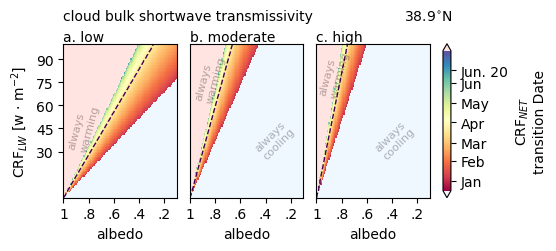

In [23]:
#fig,axx = plt.subplots(1, 5, figsize=(6,2), gridspec_kw={'width_ratios': [.4, 1,1,1,.07]}, sharey=False)
fig,axx = plt.subplots(1, 4, figsize=(5,2), gridspec_kw={'width_ratios': [1,1,1,.07]}, sharey=False)

cmap    = plt.get_cmap('Spectral')
cmap.set_under('aliceblue')
cmap.set_over('mistyrose')


def plotmat(dmat,ax):
    x,y = np.meshgrid(albedo_vec, crflwnet)
    c=ax.pcolormesh(x, y, dmat, cmap=cmap, vmax=200, vmin=-15)# shading='auto')
    ax.contour(x,y,dmat, levels=[31+28+20], linecolors='black', linewidths=1, linestyles='--')
    ax.set_xlabel('albedo')
    ax.set_ylabel("")
    ax.set_xlim(1,.1)
    ax.set_ylim(25,90)
    return c 

crf_lab = r'CRF$_{LW}$ [w $\cdot$ m$^{-2}$]'
cb = plotmat(dmat4, axx[0])
cb = plotmat(dmat5, axx[1])
cb = plotmat(dmat6, axx[2])
cbar = fig.colorbar(cb, cax=axx[3], extend='both')
cbar.set_ticks(labelist)
cbar.set_ticklabels(molistnames)
cbar.set_label(r"CRF$_{NET}$" + "\ntransition Date")
#########################################
lp = .24 # * .9
w  = .1  #* .9
h  = .15 
tp = .3
dtp = .3


for j in [1,2]:
    axx[j].set_yticklabels([])
    axx[j].set_yticks([])

for j in [0,1,2]:
    axx[j].set_xticks([1., .8,.6,.4,.2])
    axx[j].set_xticklabels(["1", ".8", ".6", ".4", ".2"])
    
    
axx[0].text(0, 1.02, r"a. low",  transform=axx[0].transAxes, fontsize=10)
axx[1].text(0, 1.02, r"b. moderate",  transform=axx[1].transAxes, fontsize=10)
axx[2].text(0, 1.02, r"c. high", transform=axx[2].transAxes, fontsize=10)




axx[0].set_yticks([30, 45, 60, 75, 90])

for j in [0,1,2]:
    axx[j].set_ylim(0,100)


axx[0].text(.97, 30, 'always\nwarming', rotation=75, alpha=.3, fontsize=8)

axx[1].text(.97, 62, 'always\nwarming', rotation=75, alpha=.3, fontsize=8)
axx[1].text(.5, 25,  'always\ncooling', rotation=45, alpha=.3, fontsize=8)

axx[2].text(.99, 65, 'always\nwarming', rotation=75, alpha=.3, fontsize=8)
axx[2].text(.55, 25, 'always\ncooling', rotation=45, alpha=.3, fontsize=8)


axx[0].text(0, 1.15, r"cloud bulk shortwave transmissivity",  transform=axx[0].transAxes, fontsize=10)
axx[0].text(3.0, 1.15, r"38.9$^{\circ}$N", transform=axx[0].transAxes, fontsize=10)
axx[0].set_ylabel(crf_lab)
plt.subplots_adjust(wspace=.15)

#plt.savefig("/global/homes/r/rudisill/gshare2/will_data/cre_project_images/FigureX_ideal_transition", dpi=300, bbox_inches="tight")

#axx[2].scatter(mdf1d.loc["2022-04-01":"2022-04-01"].albedo, mdf1d.loc["2022-05-01":"2022-05-01"].cre_lw)

### combine them both into one plot

/tmp/ipykernel_1576255/2763920459.py:11: UserWarning: The following kwargs were not used by contour: 'linecolors'
  ax.contour(x,y,dmat, levels=[31+28+20], linecolors='black', linewidths=1, linestyles='--')


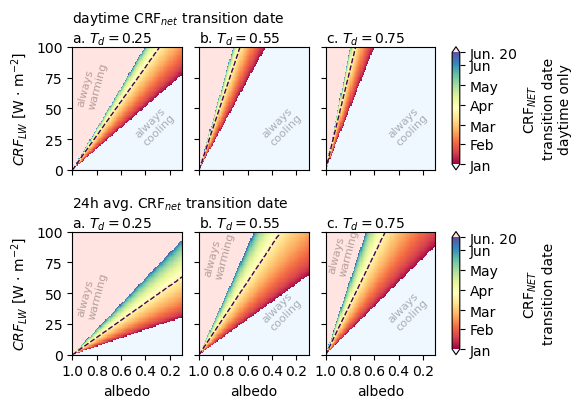

In [24]:
fig,axx = plt.subplots(2, 4, figsize=(5,4), gridspec_kw={'width_ratios': [1,1,1,.07]}, sharey=False)

cmap    = plt.get_cmap('Spectral')
cmap.set_under('aliceblue')
cmap.set_over('mistyrose')


def plotmat(dmat,ax):
    x,y = np.meshgrid(albedo_vec, crflwnet)
    c=ax.pcolormesh(x, y, dmat, cmap=cmap, vmax=170, vmin=0)# shading='auto')
    ax.contour(x,y,dmat, levels=[31+28+20], linecolors='black', linewidths=1, linestyles='--')
    ax.set_xlabel('albedo')
    ax.set_ylabel("")
    ax.set_xlim(1,.1)
    ax.set_ylim(0,100)
    return c 

crf_lab = r'CRF$_{LW}$ [w $\cdot$ m$^{-2}$]'

# daytime only 
cb = plotmat(dmat4, axx[0,0])
cb = plotmat(dmat5, axx[0,1])
cb = plotmat(dmat6, axx[0,2])

# net 
cb = plotmat(dmat1, axx[1,0])
cb = plotmat(dmat2, axx[1,1])
cb = plotmat(dmat3, axx[1,2])

for z in [0,1,2]:
    axx[0,z].set_xlabel("")
    axx[0,z].set_xticklabels([])


for j in [0,1]:
    for z in [1,2]:
        axx[j,z].set_yticklabels([])

for axz in axx.flatten():
    axz.set_xticks([1., .8,.6,.4,.2])


cbar = fig.colorbar(cb, cax=axx[0,3], extend='both')
cbar.set_ticks(labelist)
cbar.set_ticklabels(molistnames)
cbar.set_label(r"CRF$_{NET}$" + "\ntransition date\ndaytime only")


cbar = fig.colorbar(cb, cax=axx[1,3], extend='both')
cbar.set_ticks(labelist)
cbar.set_ticklabels(molistnames)
cbar.set_label(r"CRF$_{NET}$" + "\ntransition date")


# label the y labels 
axx[0,0].set_ylabel("$CRF_{LW}$ [W $\cdot$ m$^{-2}$]")
axx[1,0].set_ylabel("$CRF_{LW}$ [W $\cdot$ m$^{-2}$]")

# top row
axx[0,0].text(.97, 50, 'always\nwarming', rotation=75, alpha=.3, fontsize=8)
axx[0,0].text(.5, 20, 'always\ncooling', rotation=45, alpha=.3, fontsize=8)

axx[0,1].text(.5, 20, 'always\ncooling', rotation=45, alpha=.3, fontsize=8)
axx[0,2].text(.5, 20, 'always\ncooling', rotation=45, alpha=.3, fontsize=8)
axx[1,2].text(.5, 20, 'always\ncooling', rotation=45, alpha=.3, fontsize=8)
axx[1,1].text(.5, 20,  'always\ncooling', rotation=45, alpha=.3, fontsize=8)


# bottom row 
axx[1,0].text(.97, 30, 'always\nwarming', rotation=75, alpha=.3, fontsize=8)
axx[1,1].text(.97, 62, 'always\nwarming', rotation=75, alpha=.3, fontsize=8)
axx[1,2].text(.99, 65, 'always\nwarming', rotation=75, alpha=.3, fontsize=8)

## label 
axx[0,0].text(0, 1.2, r"daytime CRF$_{net}$ transition date",  transform=axx[0,0].transAxes, fontsize=10)
axx[0,0].text(0, 1.03, r"a. $T_d=0.25$",  transform=axx[0,0].transAxes, fontsize=10)
axx[0,1].text(0, 1.03, r"b. $T_d=0.55$",  transform=axx[0,1].transAxes, fontsize=10)
axx[0,2].text(0, 1.03, r"c. $T_d=0.75$", transform=axx[0,2].transAxes, fontsize=10)    

axx[1,0].text(0, 1.2, r"24h avg. CRF$_{net}$ transition date",  transform=axx[1,0].transAxes, fontsize=10)
axx[1,0].text(0, 1.03, r"a. $T_d=0.25$",  transform=axx[1,0].transAxes, fontsize=10)
axx[1,1].text(0, 1.03, r"b. $T_d=0.55$",  transform=axx[1,1].transAxes, fontsize=10)
axx[1,2].text(0, 1.03, r"c. $T_d=0.75$", transform=axx[1,2].transAxes, fontsize=10)    
fig.subplots_adjust(hspace=.5)

#plt.savefig("/global/homes/r/rudisill/gshare2/will_data/cre_project_images/FigureX_ideal_transition", dpi=300, bbox_inches="tight")
#

In [25]:
cza_24h = df.cza.clip(lower=0).resample("1d").mean()
czaday  = df.cza.where(df.cza>0).dropna().resample("1d").mean()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


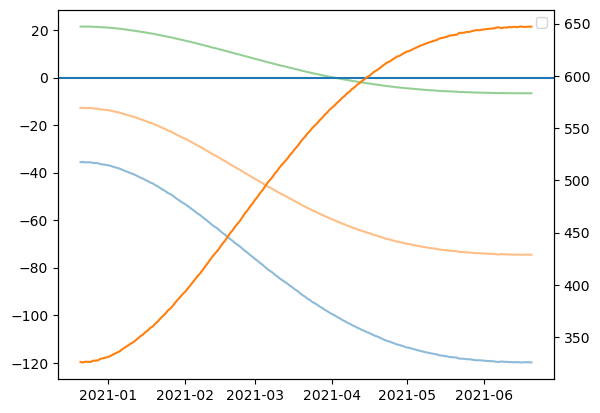

In [26]:
fig,ax=plt.subplots()
radclr = czaday["2020-12-21":"2021-06-20"]*1365*.8


#ax.plot(czaday["2020-12-21":"2021-06-20"]*1365*.8*.25 - radclr, color='tab:blue', alpha=.5)
#ax.plot(czaday["2020-12-21":"2021-06-20"]*1365*.8*.45 - radclr, color='tab:blue', alpha=.5)
#ax.plot(czaday["2020-12-21":"2021-06-20"]*1365*.8*.75 - radclr, color='tab:blue', alpha=.5)


ax2 = ax.twinx()
ax2.plot(radclr, color='tab:orange', alpha=1.)
ax.plot(50 + (1-.65) * ((.25 -1 ) * radclr), alpha=.5, label='Td = .25')
ax.plot(50 + (1-.65) * ((.45 -1 ) * radclr), alpha=.5, label='Td = .45')
ax.plot(50 + (1-.65) * ((.75 -1 ) * radclr), alpha=.5, label='Td = .75')
plt.legend()
ax.axhline(0)
# ax.plot(cza_24h["2020-12-21":"2021-06-20"]*1365*.8,     color='tab:orange', alpha=1.)
# ax.plot(cza_24h["2020-12-21":"2021-06-20"]*1365*.8*.25, color='tab:orange', alpha=.5)
# ax.plot(cza_24h["2020-12-21":"2021-06-20"]*1365*.8*.45, color='tab:orange', alpha=.5)
# ax.plot(cza_24h["2020-12-21":"2021-06-20"]*1365*.8*.75, color='tab:orange', alpha=.5)


In [27]:
def return_date_closest_to_value(df, value):
    difference = ((df - value)**2)
    if difference.min() > .5:
        if value >= df.min():
            return -9999
        if value <= df.min():
            return 9999
    else: 
        return difference.idxmin().dayofyear




cza_24h = df.cza.clip(lower=0).resample("1d").mean()
czaday  = df.cza.where(df.cza>0).dropna().resample("1d").mean()


albedo_vecx = np.linspace(.99, .01, 250)
crfsxw      = np.linspace(-400, 0,  250)
radclr      = cza_24h["2020-01-01":"2021-06-20"]*1365*.8

td = .5
dmatx = np.zeros((len(crfsxw), len(albedo_vecx)))
for j,albedo in enumerate(albedo_vecx):
    for i,sw in enumerate(crfsxw):
        # this is the key line 
        # compute crf 
        crf = (1-albedo) * radclr["2021-01-01":"2021-06-20"] * (td - 1 )
        dmatx[i,j] = return_date_closest_to_value(crf, sw)


/tmp/ipykernel_1576255/2134060938.py:25: UserWarning: The following kwargs were not used by contour: 'linecolors'
  mar20 = ax.contour(x,y, dmatx, levels=[31+28+20], linecolors='black', linewidths=1, linestyles='--')
/tmp/ipykernel_1576255/2134060938.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  axx2.set_yticklabels(axx2.get_yticklabels(), color='tab:orange')
/tmp/ipykernel_1576255/2134060938.py:181: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


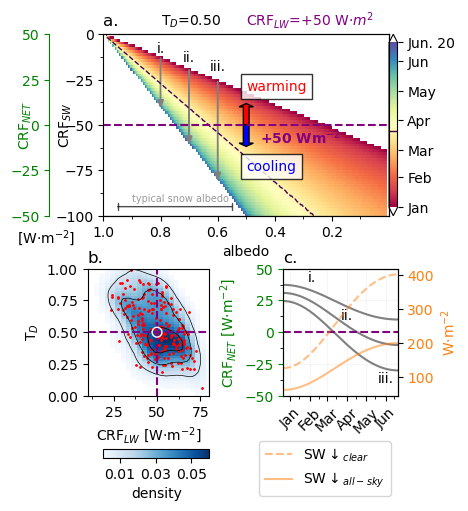

In [238]:
#fig, axx = plt.subplots(2, figsize=(5,5))
# Create the figure and gridspec
from matplotlib import gridspec
fig = plt.figure(figsize=(4, 5.5))
gs = gridspec.GridSpec(3, 5, height_ratios=[1,.7,.05], width_ratios=[.15, 1, .7, 1, .08])

# Define the axes for each subplot
ax = fig.add_subplot(gs[0, 1:4])
ax1 = fig.add_subplot(gs[1, 3:])
ax2 = fig.add_subplot(gs[1, 0:2])
cax = fig.add_subplot(gs[0, 4])
cax2 = fig.add_subplot(gs[2, 1:2])



cmap    = plt.get_cmap('Spectral')
cmap.set_under('none')
cmap.set_over('none')
x,y = np.meshgrid(albedo_vecx, crfsxw)

cb=ax.pcolormesh(x, y, dmatx, cmap=cmap, vmin=0, vmax=170)
ax.set_xlim(1,.0)
ax.set_ylim(-200,0)
ax.set_xticks([1., .8,.6,.4,.2])
mar20 = ax.contour(x,y, dmatx, levels=[31+28+20], linecolors='black', linewidths=1, linestyles='--')


cbar = fig.colorbar(cb, cax=cax, extend='both')
cbar.set_ticks(labelist)
cbar.set_ticklabels(molistnames)
ax.axhline(-100, color='gray', alpha=.1, zorder=2)

ax.set_xlabel("albedo")

cbar.add_lines(mar20)



def make_a_plot(albedo, axx, crflw=50):
    albedo_example = albedo
    crfexample = (1-albedo_example) * radclr * (td - 1 )
    y0 = crfexample['2021-01-01']
    dy = crfexample['2021-06-20'] - y0 
    ax.arrow(albedo_example, y0, 0, dy, head_width=.02, length_includes_head=True, color='gray', head_length=4)# fc='k', ec='k')
    ## plot another thing 
    (crfexample + crflw).plot(ax=axx, color='gray')

make_a_plot(.8, ax1)
make_a_plot(.7, ax1)
make_a_plot(.6, ax1)

#ax1.legend()
axx2 = ax1.twinx()
radclr.plot(ax=axx2, color='tab:orange', linestyle='--', alpha=.5, label='SW$\downarrow_{clear}$')
(td*radclr).plot(ax=axx2, color='tab:orange', alpha=.5, label='SW$\downarrow_{all-sky}$')

ax1.set_ylabel("CRF$_{NET}$ [W$\cdot$m$^{-2}$]", color='green')
ax1.set_ylim(-100,0)
#ax1.yticks()

axx2.set_ylabel("W$\cdot$m$^{-2}$")
axx2.yaxis.label.set_color('tab:orange')
axx2.set_yticklabels(axx2.get_yticklabels(), color='tab:orange')


ax.text(.8, -10, 'i.', ha='center')
ax.text(.7, -15, 'ii.', ha='center')
ax.text(.6, -20, 'iii.', ha='center')


ax1.text(pd.to_datetime("2021-02-05"), 50-10, 'i.', ha='center')
ax1.text(pd.to_datetime("2021-04-01"), 50-40, 'ii.', ha='center')
ax1.text(pd.to_datetime("2021-06-01"), 50-90, 'iii.', ha='center')
#ax1.axvline(pd.to_datetime("2021-03-20"), color='gray', linestyle='--', alpha=.5)

ax.text(.2, 1.05, "T$_D$=0.50", transform=ax.transAxes)
ax.text(.5, 1.05, "CRF$_{LW}$=+50 W$\cdot$$m^2$", transform=ax.transAxes, color='purple')


# make another plot...
ax2, trans_pcolor = make_trans_plot(ax2)
cbar2 = fig.colorbar(trans_pcolor, cax=cax2, orientation='horizontal')

plt.subplots_adjust(hspace=.5)
ax2.axhline(.5, color='purple', linestyle='--')
ax2.axvline(50, color='purple', linestyle='--')

ax.axhline( -50, color='purple', linestyle='--')
ax1.grid(alpha=.1)
ax1.axhline(0, color='purple', linestyle='--')

ax.set_ylim(-100,0)
ax.text(.45, -60, "+50 Wm$^{-2}$", color='purple', fontweight='bold')


#ax.set_xticks(np.linspace(.)
ax.set_xticks([.9,.7,.5,.3,.1], minor=True)
ax2.set_xticks(np.arange(0,125,25))



# label all of the subplots 
ax.text(0,  1.05, "a.", transform=ax.transAxes,  fontsize=12)
ax2.text(0, 1.05, "b.", transform=ax2.transAxes, fontsize=12)
ax1.text(0, 1.05, "c.", transform=ax1.transAxes, fontsize=12)


# draw even more arrows
ax.arrow(.5, -50, 0, 10, head_width=0.05, head_length=1.8, facecolor='red', width=.02)
ax.arrow(.5, -50, 0, -10, head_width=0.05, head_length=1.8, facecolor='blue', width=.02)

# more text...
t0=ax.text(.5, -31, "warming", color='red')
t1=ax.text(.5, -75, "cooling", color='blue')

t0.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='black'))
t1.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='black'))



### add a thing to show the typical snow albedo
con = ConnectionPatch(
    # in axes coordinates
    xyA =(0.95, -95), coordsA = ax.transData,
    # x in axes coordinates, y in data coordinates
    xyB =(0.55, -95), coordsB = ax.transData,
    mutation_scale=2.5,
    alpha=.7,
    arrowstyle ="|-|")
 
fig.add_artist(con)

ax.text(.9, -92, "typical snow albedo", color='black', fontsize=7, alpha=.4)

# fiddle with the secondary axis

### add a second y axis ..
#ax.set_yticks([-100,-75,-50,-25,0])
ax.set_yticks(np.arange(-100, 25, 25))
ax.set_yticks(np.arange(-100, 0, 25) + 12.5, minor=True)

ax01 = ax.twinx()
ax01.spines["left"].set_position(("axes", -.19)) # green one
ax01.yaxis.set_label_position('left')
ax01.yaxis.tick_left()


constant_shift = 50
yticks_2 = [tick + constant_shift for tick in ax.get_yticks()]
ax01.set_yticks(yticks_2)
ax01.tick_params(axis='y', colors='green')
ax01.spines['left'].set_color('green')

ax.set_ylabel("")
ax01.set_ylabel("") # W$\cdot$m$^{-2}$")
ax01.yaxis.label.set_color("green")

#ax01.text(-.25, .8, "[W$\cdot$m$^{-2}$]", transform=ax01.transAxes, color='black', rotation=90, va='center', ha='center')
ax01.text(-.13, .5, "CRF$_{SW}$",       transform=ax01.transAxes, color='black', rotation=90, va='center', ha='center')
ax01.text(-.27, .5, "CRF$_{NET}$",      transform=ax01.transAxes, color='green', rotation=90, va='center', ha='center')
ax01.text(-.2, -.12, "[W$\cdot$m$^{-2}$]",  transform=ax01.transAxes, color='black', rotation=0, va='center', ha='center')

# ax.text(.95, -75, 'clouds always\n warming', color='lightcoral')
# ax.text(.4, -20, 'clouds always\n cooling', color='lightblue')
ax2.set_xlabel("CRF$_{LW}$ [W$\cdot$m$^{-2}$]")


### fix the dataes..
major_locator = mdates.MonthLocator(bymonth=[1,2,3,4,5,6])  # Major ticks every 1 day
minor_locator = mdates.MonthLocator(bymonthday=[1,15])            # Minor ticks every 6 hours
major_formatter = mdates.DateFormatter('%b')                      # Format major ticks as 'YYYY-MM-DD'
minor_formatter = mdates.DateFormatter('')                        # Format minor ticks as 'HH:MM'

ax1.xaxis.set_major_locator(major_locator)
ax1.xaxis.set_minor_locator(minor_locator)
ax1.xaxis.set_major_formatter(major_formatter)
ax1.xaxis.set_minor_formatter(minor_formatter)
for tick in ax1.xaxis.get_major_ticks():
    tick.label1.set_horizontalalignment('center')
    tick.label1.set_rotation('horizontal')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax1.set_yticks(np.arange(-50, 75, 25))
ax1.set_yticks(np.arange(-50, 50, 25) + 12.5, minor=True)
ax2.set_xticks(np.arange(0, 100, 25) + 12.5, minor=True)

ax1.set_ylim(-50, 50)

axx2.legend(bbox_to_anchor=(1., -.3), ncol=1)

# fix the 2nd colorbar 
cbar2.set_ticks([.01, .03, .05])
cbar2.set_label("density")
ax1.tick_params(axis='y', colors='green')
ax1.spines['left'].set_color('green')

ax2.set_xlim(10,80)

ax2.scatter(50, .5, edgecolor='white', s=50, facecolor='none', zorder=10)

plt.subplots_adjust(wspace=.0)


plt.savefig("/global/homes/r/rudisill/gshare2/will_data/cre_project_images/Figure_X_ideal_transition", dpi=300, bbox_inches="tight")



In [132]:
help(fig.colorbar)

Help on method colorbar in module matplotlib.figure:

colorbar(mappable, cax=None, ax=None, use_gridspec=True, **kwargs) method of matplotlib.figure.Figure instance
    Add a colorbar to a plot.
    
    Parameters
    ----------
    mappable
        The `matplotlib.cm.ScalarMappable` (i.e., `.AxesImage`,
        `.ContourSet`, etc.) described by this colorbar.  This argument is
        mandatory for the `.Figure.colorbar` method but optional for the
        `.pyplot.colorbar` function, which sets the default to the current
        image.
    
        Note that one can create a `.ScalarMappable` "on-the-fly" to
        generate colorbars not attached to a previously drawn artist, e.g.
        ::
    
            fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    
    cax : `~matplotlib.axes.Axes`, optional
        Axes into which the colorbar will be drawn.
    
    ax : `~.axes.Axes` or list or `numpy.ndarray` of Axes, optional
        One or more parent axes from which 

In [29]:
return_date_closest_to_value(crf, -260)

9999

In [30]:
((crf  - - 260)**2).idxmin().dayofyear

171

In [61]:
kolias = xr.open_dataset("/global/homes/r/rudisill/gshare/sail_data_will/data_store_sail_period/kollias/cbh_kolias2.nc").to_pandas()
cloud_present_kolias = kolias.copy()
cloud_present_kolias[cloud_present_kolias == -1] = 0
cloud_present_kolias[cloud_present_kolias > 6000 ] = 0
cloud_present_kolias[cloud_present_kolias > 0] = 1
master_df['cloud_present'] = cloud_present_kolias.resample("1h").mean().reindex(master_df.index)

In [79]:
help(stats.gaussian_kde)

Help on class gaussian_kde in module scipy.stats._kde:

class gaussian_kde(builtins.object)
 |  gaussian_kde(dataset, bw_method=None, weights=None)
 |  
 |  Representation of a kernel-density estimate using Gaussian kernels.
 |  
 |  Kernel density estimation is a way to estimate the probability density
 |  function (PDF) of a random variable in a non-parametric way.
 |  `gaussian_kde` works for both uni-variate and multi-variate data.   It
 |  includes automatic bandwidth determination.  The estimation works best for
 |  a unimodal distribution; bimodal or multi-modal distributions tend to be
 |  oversmoothed.
 |  
 |  Parameters
 |  ----------
 |  dataset : array_like
 |      Datapoints to estimate from. In case of univariate data this is a 1-D
 |      array, otherwise a 2-D array with shape (# of dims, # of data).
 |  bw_method : str, scalar or callable, optional
 |      The method used to calculate the estimator bandwidth.  This can be
 |      'scott', 'silverman', a scalar constan

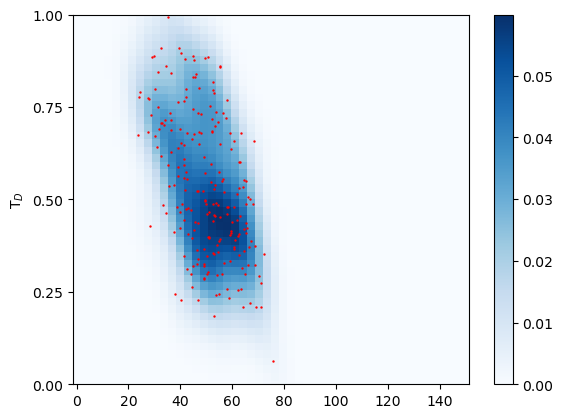

In [122]:
fig, ax = plt.subplots()
tauhr = master_df[['rrtmg_swd_clear', 'qcrad_swd', 'cloud_present']].dropna()
tau1d = tauhr.resample("1d").mean()

trans1d = tau1d.qcrad_swd / tau1d.rrtmg_swd_clear
trans1d = trans1d.where(tau1d.cloud_present > .8).dropna()
#cfrac1d = tauhr.cloud_present.resample("1d").mean()

#### do lw and transmissibvity 
xmin=0.
xmax=150.
ymin=0.
ymax=1

xdat = crf_lw.resample("1d").mean().loc[trans1d.index] #tauhr['cre_lw']
ydat = trans1d # np.exp(-1*tauhr['tauhr'])

X, Y = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([xdat, ydat])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel(positions).T, X.shape)

cfset = ax.pcolormesh(X, Y, Z, cmap='Blues')
#    cbar = fig.colorbar(cfset, ax=ax, orientation='vertical')
#   cbar.set_label('Density')


ax.scatter(xdat, ydat,  s=.5, alpha=1, color='red')
#ax.set_xlim(0,100)#[xmin, xmax])
ax.set_ylim(0,1.0) #[ymin, ymax])
#ax.contour(X, Y, Z, colors='k', linewidths=.5)


ax.set_ylabel(r"T$_D$")
ax.set_yticks([0, .25, .5, .75, 1])
plt.colorbar(cfset)


In [128]:
kernel.integrate_box([-10, -10], [200, 5])

0.9999999999999946

In [ ]:
cza_mean_daily = master_df.cza.clip(lower=0).resample("1d").mean()
cloud = mdf1d.tau
crf_daily_sw =  (1 - mdf1d.albedo) * S0 * t_clear * cza_mean_daily * (np.exp(-cloud * 1) - 1) 


In [ ]:
crf_sw = (1-mdf1d.albedo)*(mdf1d.qcrad_swd - mdf1d.rrtmg_swd_clear)

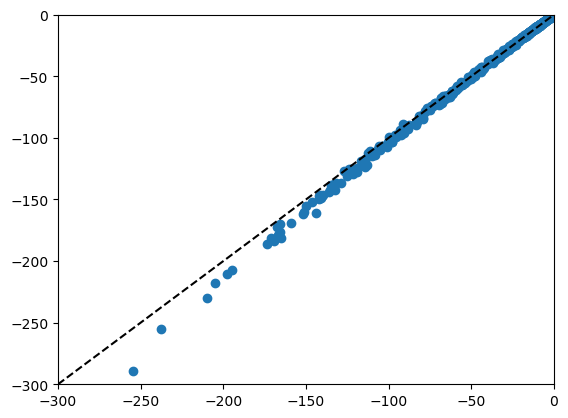

In [ ]:
plt.scatter(crf_sw, crf_daily_sw)
plt.xlim(-300,0)
plt.ylim(-300,0)
plt.plot([-300,0], [-300,0], 'k--')

#### now look at the effects of different slopes and aspects 


Text(0.45, 0.7, 'Slope=30$^{\\circ}$')

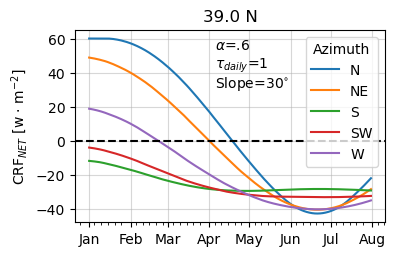

In [ ]:
### adjust the cosine of the solar zenith angle for the slope and the angle of the terrain
def cosi_adj(theta_n, psi_n, theta_i, psi_i):
    # theta i is the slope -- radians from the horizontal plane 
    # psi i is the aspect -- radians from north
    # theta n is the solar zenith angle -- radians from zenith
    # psi n is the solar azimuth angle -- radians from north
    cosi_adj =  np.cos(theta_i)* np.cos(theta_n)  + np.sin(theta_n) * np.sin(theta_i) * np.cos(psi_i - psi_n)
    return cosi_adj

latitude  = 38.980762   
longitude = -107.005017 

dr = pd.date_range(start='2021-01-01 00:00', end='2021-08-01 00:00', freq='30min')
df = pd.DataFrame(dr, columns=['datetime'])
df['solar_az'] = df['datetime'].apply(lambda x: calculate_solar_az(latitude, longitude, x))
df['solar_zen'] = df['datetime'].apply(lambda x: calculate_solar_cos_zenith(x, latitude, longitude))
df['solar_zen'] = np.arccos(df['solar_zen'])
df = df.set_index("datetime")


def cre_by_slope_and_azimuth(df, slope, azimuth, lw, albedo, cloud):
    cosi_adjx = cosi_adj(slope, azimuth, df['solar_zen'], df['solar_az']).clip(lower=0).resample("1d").mean()
    cfrac = 1 
    t_clear = .8
    S0 = 1365.
    cza_mean_daily = cosi_adjx.clip(lower=0).resample("1d").mean()
    x = lw + (1 - albedo) * S0 * t_clear * cza_mean_daily * (np.exp(-cloud * cfrac) - 1) 

    return pd.DataFrame(index=cosi_adjx.index, data={'crf':x})


slope1    = np.deg2rad(30)   # 45 degrees 
slope2    = np.deg2rad(60)   # 60 degrees


fig,ax=plt.subplots(figsize=(4, 2.5))

#for azim in np.arange(0, 360, 45):
lablist = ['N', 'NE', 'S', 'SW', 'W']
for i,azim in enumerate([0,  45, 180, 225, 270]):
    x = cre_by_slope_and_azimuth(df, slope1, np.deg2rad(azim), 60, .6, 1)
    ax.plot(x.index[:-1], x[:-1], label=lablist[i],) #label=f'{azim:.0f}')


leg = ax.legend()
leg.set_title("Azimuth")

ax.axhline(0, linestyle='--',   color='black')

ax.set_title("39.0 N")
ax.set_ylabel("CRF$_{NET}$ [w $\cdot$ m$^{-2}$]")
ax.grid(alpha=.5)


major_locator = mdates.MonthLocator(bymonth=[1, 2, 3, 4, 5, 6, 7, 8])  # Major ticks every 1 day
minor_locator = mdates.MonthLocator(bymonthday=np.arange(5, 30, 5))          
major_formatter = mdates.DateFormatter('%b')                      # Format major ticks as 'YYYY-MM-DD'
minor_formatter = mdates.DateFormatter('')                        # Format minor ticks as 'HH:MM'

ax.xaxis.set_major_locator(major_locator)
ax.xaxis.set_minor_locator(minor_locator)
ax.xaxis.set_major_formatter(major_formatter)
ax.xaxis.set_minor_formatter(minor_formatter)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_horizontalalignment('center')
    tick.label1.set_rotation('horizontal')


ax.text(0.45, 0.9, r'$\alpha$=.6',  transform=ax.transAxes)
ax.text(0.45, 0.8, r'$\tau_{daily}$=1',  transform=ax.transAxes)
ax.text(0.45, 0.7, r'Slope=30$^{\circ}$',  transform=ax.transAxes)
